<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Простой-автокодировщик" data-toc-modified-id="Простой-автокодировщик-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Простой автокодировщик</a></span></li><li><span><a href="#Автокодировщик-на-сверточной-сети" data-toc-modified-id="Автокодировщик-на-сверточной-сети-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Автокодировщик на сверточной сети</a></span></li><li><span><a href="#Вариационный-автокодировщик-VAE" data-toc-modified-id="Вариационный-автокодировщик-VAE-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Вариационный автокодировщик VAE</a></span></li><li><span><a href="#Зашумленный-автокодировщик" data-toc-modified-id="Зашумленный-автокодировщик-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Зашумленный автокодировщик</a></span></li><li><span><a href="#Обучить-VAE-c-переносом-стиля" data-toc-modified-id="Обучить-VAE-c-переносом-стиля-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучить VAE c переносом стиля</a></span></li></ul></div>

# Простой автокодировщик

In [21]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy
import matplotlib.pyplot as plt

In [22]:
#hyper params
num_epoch = 20
cuda_device = -1
batch_size = 128
device = f'cuda:{cuda_device}' if cuda_device != -1 else 'cpu'

epoch: 1
tensor(0.1046, grad_fn=<MseLossBackward0>)
tensor(0.0527, grad_fn=<MseLossBackward0>)
tensor(0.0346, grad_fn=<MseLossBackward0>)
tensor(0.0273, grad_fn=<MseLossBackward0>)
tensor(0.0266, grad_fn=<MseLossBackward0>)
epoch: 2
tensor(0.0224, grad_fn=<MseLossBackward0>)
tensor(0.0205, grad_fn=<MseLossBackward0>)
tensor(0.0193, grad_fn=<MseLossBackward0>)
tensor(0.0185, grad_fn=<MseLossBackward0>)
tensor(0.0189, grad_fn=<MseLossBackward0>)
epoch: 3
tensor(0.0172, grad_fn=<MseLossBackward0>)
tensor(0.0178, grad_fn=<MseLossBackward0>)
tensor(0.0155, grad_fn=<MseLossBackward0>)
tensor(0.0163, grad_fn=<MseLossBackward0>)
tensor(0.0143, grad_fn=<MseLossBackward0>)
epoch: 4
tensor(0.0152, grad_fn=<MseLossBackward0>)
tensor(0.0138, grad_fn=<MseLossBackward0>)
tensor(0.0154, grad_fn=<MseLossBackward0>)
tensor(0.0141, grad_fn=<MseLossBackward0>)
tensor(0.0133, grad_fn=<MseLossBackward0>)
epoch: 5
tensor(0.0126, grad_fn=<MseLossBackward0>)
tensor(0.0132, grad_fn=<MseLossBackward0>)
tensor(0.

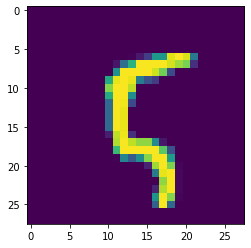

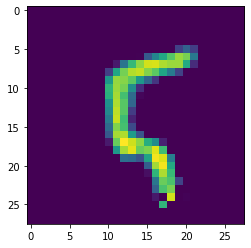

In [30]:
#model

class Encoder(nn.Module):
    # 28*28 -> hidden -> out
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0, 1)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(0, 1)
        self.linear3 = nn.Linear(hidden_dim, latent_dim)
        
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = self.dropout1(self.activation(self.linear1(x)))
        x = self.dropout2(self.activation(self.linear2(x)))
        x = self.activation(self.linear3(x))
            
        return x
        
class Decoder(nn.Module):
    # encoder_out -> hidden -> 28*28
    def __init__(self, latent_dim, hidden_dim, out_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0, 1)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(0, 1)
        self.linear3 = nn.Linear(hidden_dim, out_dim)
        
        self.activation = nn.ReLU()


    def forward(self, x):
        x = self.dropout1(self.activation(self.linear1(x)))
        x = self.dropout2(self.activation(self.linear2(x)))
        x = self.activation(self.linear3(x))
            
        return x

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x
    
def collate_fn(data):
    pics = []
    target = []
    for item in data:

        pics.append(numpy.array(item[0]))
        target.append(item[1])
    return {
        'data': torch.from_numpy(numpy.array(pics)).float() / 255,
        'target': torch.from_numpy(numpy.array(target)),
    }

# model
model = AutoEncoder(28*28, 300, 64)
model.train()
model.to(device)

#optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.001)

#dataset
dataset = datasets.MNIST('F:/Разное/Программирование/Школа Data Scientist/Project/Task 11 MNIST Полносвязная и сверточная сети', download=False)

#loss
loss_func = nn.MSELoss()

#dataloder
for epoch in range(20):
    dataloader = DataLoader(
        dataset=dataset,
        collate_fn=collate_fn,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )
    print(f'epoch: {epoch + 1}')
    for step, batch in enumerate(dataloader):
        data = batch['data'].to(device).view(batch['data'].size(0), -1)
        optim.zero_grad()
        predict = model(data)
        loss = loss_func(predict, data)
        loss.backward()
        optim.step()
        if (step % 100 == 0):
            print(loss)
    
test = dataset.data[100].view(1,-1).float() / 255
predict = model(test)

plt.imshow(test[0].view(28,28).detach().numpy())
plt.show()

plt.imshow(predict[0].view(28,28).detach().numpy())
plt.show()

# Автокодировщик на сверточной сети

epoch: 1
tensor(0.1027, grad_fn=<MseLossBackward0>)
tensor(0.0138, grad_fn=<MseLossBackward0>)
tensor(0.0100, grad_fn=<MseLossBackward0>)
tensor(0.0080, grad_fn=<MseLossBackward0>)
tensor(0.0074, grad_fn=<MseLossBackward0>)


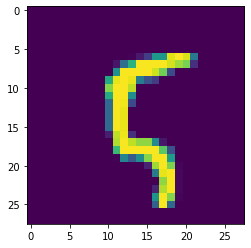

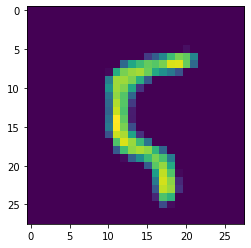

In [5]:
class Encoder(nn.Module):
    # #conv2d -> maxpool2d -> conv2d -> maxpool2d -> conv2d
    def __init__(self, in_chan, hidden_chan):
        super().__init__()
        self.conv1 = nn.Conv2d(in_chan, hidden_chan, kernel_size = 5, stride = 1, padding = 2) # 28*28
        self.pool1 = nn.MaxPool2d(2, 2) # 14*14
        self.conv2 = nn.Conv2d(hidden_chan, hidden_chan, kernel_size = 3, stride = 1, padding = 1) # 14*14
        self.pool2 = nn.MaxPool2d(2, 2) # 7*7
        self.conv3 = nn.Conv2d(hidden_chan, 1, kernel_size = 3, stride = 1, padding = 1)
                
        self.activation = nn.ReLU()
        
    def forward(self, x): # 7*7
        x = self.activation(self.pool1(self.conv1(x)))
        x = self.activation(self.pool2(self.conv2(x)))
        x = self.activation(self.conv3(x))
          
        return x
        
class Decoder(nn.Module):
    # conv2d -> upsampling2d -> conv2d -> upsampling2d -> conv2d
    def __init__(self, in_chan, hidden_chan):
        super().__init__()
        self.conv1 = nn.Conv2d(1, hidden_chan, kernel_size = 3, stride = 1, padding = 1) # 7*7
        self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # > 14 x 14
        self.conv2 = nn.Conv2d(hidden_chan, hidden_chan, kernel_size=3, stride=1, padding=1)  # > 14 x 14
        self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2)  # 28 x 28
        self.conv3 = nn.Conv2d(hidden_chan, in_chan, kernel_size=5, stride=1, padding=2)
                
        self.activation = nn.ReLU()


    def forward(self, x): # 28*28
        x = self.activation(self.upsample1(self.conv1(x)))
        x = self.activation(self.upsample2(self.conv2(x)))
        x = self.activation(self.conv3(x))
    
        return x

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim)
        self.decoder = Decoder(input_dim, hidden_dim)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x
    
def collate_fn(data):
    pics = []
    target = []
    for item in data:

        pics.append(numpy.array(item[0]))
        target.append(item[1])
    return {
        'data': torch.from_numpy(numpy.array(pics)).float() / 255,
        'target': torch.from_numpy(numpy.array(target)),
    }

# model
model = AutoEncoder(1, 50)
model.train()
model.to(device)

#optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.001)

#dataset
dataset = datasets.MNIST('F:/Разное/Программирование/Школа Data Scientist/Project/Task 11 MNIST Полносвязная и сверточная сети', download=False)

#loss
loss_func = nn.MSELoss()

#dataloder
for epoch in range(1):
    dataloader = DataLoader(
        dataset=dataset,
        collate_fn=collate_fn,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )
    print(f'epoch: {epoch + 1}')
    for step, batch in enumerate(dataloader):
        data = batch['data'].to(device).unsqueeze(1)
        optim.zero_grad()
        predict = model(data)
        loss = loss_func(predict, data)
        loss.backward()
        optim.step()
        if (step % 100 == 0):
            print(loss)
    
test = dataset.data[100].unsqueeze(0).unsqueeze(0).float() / 255
predict = model(test)

plt.imshow(test[0][0].view(28, 28).detach().numpy())
plt.show()

plt.imshow(predict[0][0].squeeze().detach().numpy())

# Вариационный автокодировщик VAE

In [ ]:
class Encoder(nn.Module):
    # #conv2d -> maxpool2d -> conv2d -> maxpool2d -> conv2d
    def __init__(self, in_chan, hidden_chan):
        super().__init__()
        self.conv1 = nn.Conv2d(in_chan, hidden_chan, kernel_size = 5, stride = 1, padding = 2) # 28*28
        self.pool1 = nn.MaxPool2d(2, 2)# 14*14
        self.conv2 = nn.Conv2d(hidden_chan, hidden_chan, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(hidden_chan, hidden_chan, kernel_size = 3, stride = 1, padding = 1) # 14*14
        self.pool2 = nn.MaxPool2d(2, 2) # 7*7
        self.conv4 = nn.Conv2d(hidden_chan, hidden_chan, kernel_size = 2, stride = 2, padding = 4)
        
        self.conv_mu = nn.Conv2d(hidden_chan, 1, kernel_size=3, stride=1, padding=1)
        self.conv_sigma = nn.Conv2d(hidden_chan, 1, kernel_size=3, stride=1, padding=1)
                
        self.activation = nn.ReLU()
        
    def forward(self, x): # 7*7
        x = self.activation(self.pool1(self.conv1(x)))
        x = self.activation(self.conv2(x))
        x = self.activation(self.pool2(self.conv3(x)))
        x = self.activation(self.conv4(x))
        
        return self.activation(self.conv_mu(x)), torch.exp(self.conv_sigma(x))

# sampling
def sampling(mu, sigma):
    return mu + sigma * torch.normal(torch.zeros_like(mu), torch.ones_like(mu))
        
class Decoder(nn.Module):
    # conv2d -> upsampling2d -> conv2d -> upsampling2d -> conv2d
    def __init__(self, in_chan, hidden_chan):
        super().__init__()
        self.conv1 = nn.Conv2d(1, hidden_chan, kernel_size = 2, stride = 2, padding = 4)
        self.conv2 = nn.Conv2d(hidden_chan, hidden_chan, kernel_size = 3, stride = 1, padding = 1) # 7*7
        self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # > 14 x 14
        self.conv3 = nn.Conv2d(hidden_chan, hidden_chan, kernel_size = 3, stride = 1, padding = 1)
        self.conv4 = nn.Conv2d(hidden_chan, hidden_chan, kernel_size=3, stride=1, padding=1)  # > 14 x 14
        self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2)  # 28 x 28
        self.conv5 = nn.Conv2d(hidden_chan, in_chan, kernel_size=5, stride=1, padding=2)
                
        self.activation = nn.ReLU()


    def forward(self, x): # 28*28
        x = self.activation(self.conv1(x))
        x = self.activation(self.upsample1(self.conv2(x)))
        x = self.activation(self.conv3(x))
        x = self.activation(self.upsample2(self.conv4(x)))
        x = self.activation(self.conv5(x))
            
        return x

class AutoEncoderVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim)
        self.decoder = Decoder(input_dim, hidden_dim)
        
    def forward(self, x):
        mu, sigma = self.encoder(x)
        x = self.decoder(sampling(mu, sigma))

        return x, mu, sigma

def collate_fn(data):
    pics = []
    target = []
    for item in data:

        pics.append(numpy.array(item[0]))
        target.append(item[1])
    return {
        'data': torch.from_numpy(numpy.array(pics)).float() / 255,
        'target': torch.from_numpy(numpy.array(target)),
    }

def kl_loss(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(sigma))

    return torch.distributions.kl_divergence(p, q).mean()

# model
model = AutoEncoderVAE(1, 200)
model.train()
model.to(device)

#optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.001)

#dataset
dataset = datasets.MNIST('F:/Разное/Программирование/Школа Data Scientist/Project/Task 11 MNIST Полносвязная и сверточная сети', download=False)

#loss
criterion = nn.MSELoss()

#dataloder
for epoch in range(3):
    dataloader = DataLoader(
        dataset=dataset,
        collate_fn=collate_fn,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )
    print(f'epoch: {epoch + 1}')
    for step, batch in enumerate(dataloader):
        data = batch['data'].to(device).unsqueeze(1)
        optim.zero_grad()
        predict, mu, sigma = model(data)
        #loss
        loss = kl_loss(mu, sigma) + criterion(data, predict)
        loss.backward()
        optim.step()
        if (step % 100 == 0):
            print(loss)

test = dataset.data[100].unsqueeze(0).unsqueeze(0).float() / 255
predict = model(test)

plt.imshow(test[0][0].view(28, 28).detach().numpy())
plt.show()

plt.imshow(predict[0][0].squeeze().detach().numpy())

epoch: 1
tensor(0.1187, grad_fn=<AddBackward0>)
tensor(0.0659, grad_fn=<AddBackward0>)
tensor(0.0663, grad_fn=<AddBackward0>)
tensor(0.0674, grad_fn=<AddBackward0>)
tensor(0.0723, grad_fn=<AddBackward0>)
epoch: 2
tensor(0.0671, grad_fn=<AddBackward0>)
tensor(0.0659, grad_fn=<AddBackward0>)
tensor(0.0647, grad_fn=<AddBackward0>)
tensor(0.0690, grad_fn=<AddBackward0>)


# Зашумленный автокодировщик

epoch: 1


C:\Users\DNS\anaconda3\lib\site-packages\torch\autograd\__init__.py:154: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(


tensor(0.1004, grad_fn=<MseLossBackward0>)
tensor(0.0529, grad_fn=<MseLossBackward0>)
tensor(0.0438, grad_fn=<MseLossBackward0>)
tensor(0.0427, grad_fn=<MseLossBackward0>)
tensor(0.0419, grad_fn=<MseLossBackward0>)
epoch: 2
tensor(0.0415, grad_fn=<MseLossBackward0>)
tensor(0.0403, grad_fn=<MseLossBackward0>)
tensor(0.0414, grad_fn=<MseLossBackward0>)
tensor(0.0402, grad_fn=<MseLossBackward0>)
tensor(0.0397, grad_fn=<MseLossBackward0>)


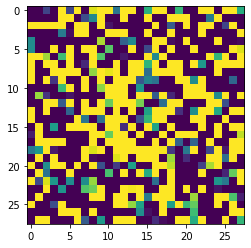

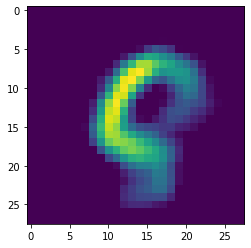

In [3]:
class Encoder(nn.Module):
    # #conv2d -> maxpool2d -> conv2d -> maxpool2d -> conv2d
    def __init__(self, in_chan, hidden_chan):
        super().__init__()
        self.conv1 = nn.Conv2d(in_chan, hidden_chan, kernel_size = 5, stride = 1, padding = 2) # 28*28
        self.pool1 = nn.MaxPool2d(2, 2) # 14*14
        self.conv2 = nn.Conv2d(hidden_chan, hidden_chan, kernel_size = 3, stride = 1, padding = 1) # 14*14
        self.pool2 = nn.MaxPool2d(2, 2) # 7*7
        self.conv3 = nn.Conv2d(hidden_chan, 1, kernel_size = 3, stride = 1, padding = 1)
                
        self.activation = nn.ReLU()
        
    def forward(self, x): # 7*7
        x = self.activation(self.pool1(self.conv1(x)))
        x = self.activation(self.pool2(self.conv2(x)))
        x = self.activation(self.conv3(x))
          
        return x
        
class Decoder(nn.Module):
    # conv2d -> upsampling2d -> conv2d -> upsampling2d -> conv2d
    def __init__(self, in_chan, hidden_chan):
        super().__init__()
        self.conv1 = nn.Conv2d(1, hidden_chan, kernel_size = 3, stride = 1, padding = 1) # 7*7
        self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # > 14 x 14
        self.conv2 = nn.Conv2d(hidden_chan, hidden_chan, kernel_size=3, stride=1, padding=1)  # > 14 x 14
        self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2)  # 28 x 28
        self.conv3 = nn.Conv2d(hidden_chan, in_chan, kernel_size=5, stride=1, padding=2)
                
        self.activation = nn.ReLU()


    def forward(self, x): # 28*28
        x = self.activation(self.upsample1(self.conv1(x)))
        x = self.activation(self.upsample2(self.conv2(x)))
        x = self.activation(self.conv3(x))
    
        return x

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim)
        self.decoder = Decoder(input_dim, hidden_dim)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x
    
def collate_fn(data):
    pics = []
    target = []
    for item in data:

        pics.append(numpy.array(item[0]))
        target.append(item[1])
    return {
        'data': torch.from_numpy(numpy.array(pics)).float() / 255,
        'target': torch.from_numpy(numpy.array(target)),
    }

# model
model = AutoEncoder(1, 50)
model.train()
model.to(device)

#optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.001)

#dataset
dataset = datasets.MNIST('C:/Users/DNS/Documents/Школа Data Scientist/Project/Task 11 MNIST Полносвязная и сверточная сети', download=False)

#loss
loss_func = nn.MSELoss()

#dataloder
for epoch in range(2):
    dataloader = DataLoader(
        dataset=dataset,
        collate_fn=collate_fn,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )
    print(f'epoch: {epoch + 1}')
    for step, batch in enumerate(dataloader):
        data = batch['data'].to(device).unsqueeze(1)
        data_noized = torch.clamp(data + torch.normal(torch.zeros_like(data), torch.ones_like(data)), 0., 0.5)
        optim.zero_grad()
        predict = model(data_noized)
        loss = loss_func(predict, data)
        loss.backward()
        optim.step()
        if (step % 100 == 0):
            print(loss)
    
test = dataset.data[100].unsqueeze(0).unsqueeze(0).float() / 255
test = torch.clamp(test + torch.normal(torch.zeros_like(test), torch.ones_like(test)), 0., 0.5)
predict = model(test)

plt.imshow(test[0][0].view(28, 28).detach().numpy())
plt.show()

plt.imshow(predict[0][0].squeeze().detach().numpy())

# Обучить VAE c переносом стиля

epoch: 1
tensor(0.1094, grad_fn=<MseLossBackward0>)
tensor(0.0430, grad_fn=<MseLossBackward0>)
tensor(0.0272, grad_fn=<MseLossBackward0>)
tensor(0.0238, grad_fn=<MseLossBackward0>)
tensor(0.0215, grad_fn=<MseLossBackward0>)
epoch: 2
tensor(0.0184, grad_fn=<MseLossBackward0>)
tensor(0.0169, grad_fn=<MseLossBackward0>)
tensor(0.0168, grad_fn=<MseLossBackward0>)
tensor(0.0164, grad_fn=<MseLossBackward0>)
tensor(0.0157, grad_fn=<MseLossBackward0>)
epoch: 3
tensor(0.0152, grad_fn=<MseLossBackward0>)
tensor(0.0137, grad_fn=<MseLossBackward0>)
tensor(0.0149, grad_fn=<MseLossBackward0>)
tensor(0.0137, grad_fn=<MseLossBackward0>)
tensor(0.0121, grad_fn=<MseLossBackward0>)
epoch: 4
tensor(0.0137, grad_fn=<MseLossBackward0>)
tensor(0.0120, grad_fn=<MseLossBackward0>)
tensor(0.0123, grad_fn=<MseLossBackward0>)
tensor(0.0131, grad_fn=<MseLossBackward0>)
tensor(0.0113, grad_fn=<MseLossBackward0>)
epoch: 5
tensor(0.0105, grad_fn=<MseLossBackward0>)
tensor(0.0108, grad_fn=<MseLossBackward0>)
tensor(0.

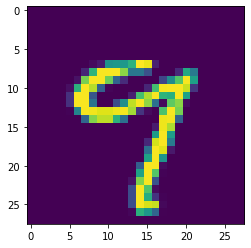

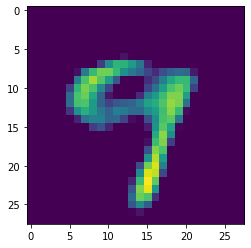

In [30]:
class Encoder(nn.Module):
    # #conv2d -> maxpool2d -> conv2d -> maxpool2d -> conv2d
    def __init__(self, in_chan, hidden_chan):
        super().__init__()
        self.conv1 = nn.Conv2d(in_chan, hidden_chan, kernel_size = 5, stride = 1, padding = 2) # 28*28
        self.pool1 = nn.MaxPool2d(2, 2) # 14*14
        self.conv2 = nn.Conv2d(hidden_chan, hidden_chan, kernel_size = 3, stride = 1, padding = 1) # 14*14
        self.pool2 = nn.MaxPool2d(2, 2) # 7*7
        self.conv3 = nn.Conv2d(hidden_chan, 1, kernel_size = 3, stride = 1, padding = 1)
                
        self.activation = nn.ReLU()
        
    def forward(self, x): # 7*7
        x = self.activation(self.pool1(self.conv1(x)))
        x = self.activation(self.pool2(self.conv2(x)))
        x = self.activation(self.conv3(x))
          
        return x
        
class Decoder(nn.Module):
    # conv2d -> upsampling2d -> conv2d -> upsampling2d -> conv2d
    def __init__(self, in_chan, hidden_chan):
        super().__init__()
        self.conv1 = nn.Conv2d(1, hidden_chan, kernel_size = 3, stride = 1, padding = 1) # 7*7
        self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # > 14 x 14
        self.conv2 = nn.Conv2d(hidden_chan, hidden_chan, kernel_size=3, stride=1, padding=1)  # > 14 x 14
        self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2)  # 28 x 28
        self.conv3 = nn.Conv2d(hidden_chan, in_chan, kernel_size=5, stride=1, padding=2)
                
        self.activation = nn.ReLU()
        self.digit_embeding = nn.Embedding(10, 40)
        self.linear = nn.Linear(49+40, 49, bias = False)

    def forward(self, x, digit): # 28*28
        digit_emb = self.digit_embeding(digit)
        x = x.view(x.size(0), -1)
        x = torch.cat([x, digit_emb], dim = -1) # B*x+Emb
        x = self.linear(x).reshape(x.size(0), 1, 7, 7)
        x = self.activation(self.upsample1(self.conv1(x)))
        x = self.activation(self.upsample2(self.conv2(x)))
        x = self.activation(self.conv3(x))
    
        return x

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim)
        self.decoder = Decoder(input_dim, hidden_dim)
        
    def forward(self, x, digit):
        x = self.encoder(x)
        x = self.decoder(x, digit)
         
        return x
    
def collate_fn(data):
    pics = []
    target = []
    for item in data:

        pics.append(numpy.array(item[0]))
        target.append(item[1])
    return {
        'data': torch.from_numpy(numpy.array(pics)).float() / 255,
        'target': torch.from_numpy(numpy.array(target)),
    }

# model
model = AutoEncoder(1, 50)
model.train()
model.to(device)

#optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.001)

#dataset
dataset = datasets.MNIST('C:/Users/DNS/Documents/Школа Data Scientist/Project/Task 11 MNIST Полносвязная и сверточная сети', download=False)

#loss
loss_func = nn.MSELoss()

#dataloder
for epoch in range(5):
    dataloader = DataLoader(
        dataset=dataset,
        collate_fn=collate_fn,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )
    print(f'epoch: {epoch + 1}')
    for step, batch in enumerate(dataloader):
        data = batch['data'].to(device).unsqueeze(1)
        optim.zero_grad()
        predict = model(data, batch['target'].to(device))
        loss = loss_func(predict, data)
        loss.backward()
        optim.step()
        if (step % 100 == 0):
            print(loss)
    
test = dataset.data[154].unsqueeze(0).unsqueeze(0).float() / 255
predict = model(test, torch.tensor([0]))

plt.imshow(test[0][0].view(28, 28).detach().numpy())
plt.show()

plt.imshow(predict[0][0].squeeze().detach().numpy())